# Goal
The goal of this notebook is to explore the correlation between new vulnerability discovery and a spike in open source software releases.

## Data
The `"release.csv"` dataset contains information pertaining to new software releases among open source software.
The NVD data sets contain information about vulnerabilities

##### Schema
The dataset contains the following columns:
`'id', 'target', 'date', 'date_offset', 'name', 'comment', 'author'`

Some fields relate to a handful of other datasets (directory info, snapshots, servers). The extra data is unnseccecary for our purposes.

## Challenges
##### Large Dataset
The full dataset is large (1.4 Gigs). A teaser dataset is being used to explore properties of the data.
##### Unclear Connection
We wish to compare this dataset with another set, NVD, which contains information about discovered software vulnerabilities.
It may be possible to directly relate and connect the two datasets. This requires exploring of the two sets.

Alternatively, we can always correlate the two.





## Project Review 2

Explore the correlation between vulnerability publish and spike in frequency.


# Code
Simple imports

Declaring column headers and path to the data (on my machine)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = [15,15]

# Releases

In [2]:
release_header = ['id', 'target', 'date', 'date_offset', 'name', 'comment', 'author']
revision_header = ['id', 'date', 'committer_date', 'directory', 'message', 'author', 'committer']
# Path to release.csv, and whether to select uncompressed or ocmpressed version
# release_path = 'D:/data/open_source/release.csv'
release_path = 'D:/data/open_source/release.csv.gz'

Some fields are stored as hexidecimal strings, this function converts it to decimal.

Also, a function to convert the incoming date string to a dateitme object.

In [3]:
def hex_str(str):
    return bytes.fromhex((str).replace('\\x','')).decode('utf-8')

def date_str(str):
    return pd.to_datetime(str, format='%Y-%m-%dT%H:%M:%S.000Z')

The data is read in and only the useful columns are kept

In [4]:
release_df = pd.read_csv(release_path, names=release_header, converters={'date':date_str,'comment':hex_str})
release_df = release_df[['id','date','name','comment','author']]

This function allows resample of the releases

In [5]:
def releases_resample(resample_by):
    return (release_df[['date','id']].set_index('date').resample( resample_by ).count()).rename(columns={'id':'count'})

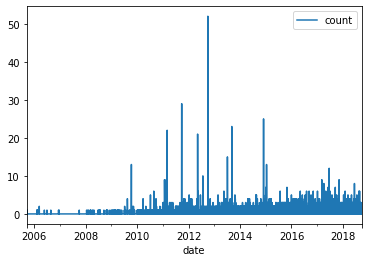

In [6]:
r_h = releases_resample('H')
r_h.plot()

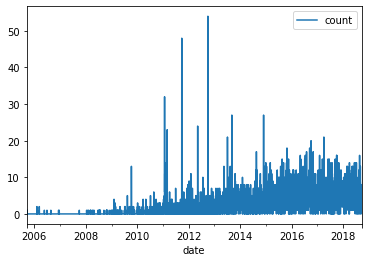

In [7]:
r_d = releases_resample('d')
r_d.plot()

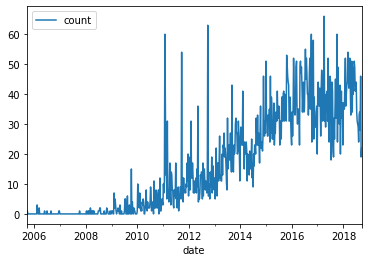

In [8]:
r_w = releases_resample('w')
r_w.plot()

In [9]:
r_d.head()

,count
date,
2005-09-16,1
2005-09-17,0
2005-09-18,0
2005-09-19,1
2005-09-20,0


Here we see spikes in the data. This may be erreoneous data.

It is possible that these spikes in `dayly` release rate is due to a response to an extreme vulnerability. This could also be due to various other factors, such as github/others servers crashing, and only pushing releases after coming back online.

# National Vulnerability Dataset
NVD Files available for download at https://nvd.nist.gov/vuln/data-feeds

In [10]:
# Path to nvd file directory
nvd_dir = 'D:/data/open_source/NVD/'

# Select file type to load
# nvd_file_type = '.json'
nvd_file_type = '.json.zip'
# nvd_file_type = '.json.gz'

In [11]:
def date_str_nvd(st):
    return pd.to_datetime( st, format='%Y-%m-%dT%H:%MZ')

def score_nvd(json):
    if json['impact'] and 'baseMetricV2' in json['impact']:
        return json['impact']['baseMetricV2']['cvssV2']['baseScore']
    else:
        return 0.0

Gather all NVD Datasets into one dataframe

In [12]:
def import_nvd(nvd_start=15, nvd_end=19):
    
    for i in range(nvd_start,nvd_end):
        
        year = '20'+str(i).zfill(2)
        path = nvd_dir+'nvdcve-1.1-'+year+nvd_file_type
        if i==nvd_start:
            nvd = pd.read_json(path, encoding="utf8")
        else:
            nvd = nvd.append( pd.read_json(path, encoding="utf8") )
    nvd = nvd.reset_index()
    return nvd.drop(['index'], 1)

def import_nvd_clean(nvd_start=2, nvd_end=20):
    
    for i in range(nvd_start,nvd_end):
        
        year = '20'+str(i).zfill(2)
        path = nvd_dir+'nvdcve-1.1-'+year+nvd_file_type
        if i==nvd_start:
            nvd = clean_nvd(pd.read_json(path, encoding="utf8"))
        else:
            nvd = nvd.append( clean_nvd(pd.read_json(path, encoding="utf8")) )
    nvd = nvd.reset_index()
    return nvd.drop(['index'], 1)
    


def clean_nvd(nvd):
    nvd['date'] = nvd['CVE_Items'].apply( lambda x: date_str_nvd(x['publishedDate']) )
    nvd['score'] = nvd['CVE_Items'].apply( lambda x: score_nvd(x) )
    new_nvd = nvd.drop(['CVE_data_type','CVE_data_format','CVE_data_version','CVE_data_numberOfCVEs','CVE_data_timestamp','CVE_Items'], 1)
    return new_nvd

`nvd` contains all NVD Vulnerability information
Not much of it is needed, and takes a lot of memory.

In [13]:
#nvd = import_nvd(15,16)

In [14]:
#nvd.head()

Nearly all useful information (date and score) is held within the JSON object in the `CVE_Items` tab.

In [15]:
#nvd['CVE_Items'][1]

All vulnerabilities within NVD have a published date accessible by

In [16]:
#nvd['CVE_Items'][1]['publishedDate']

Along with a vulnerability score, accessible by

In [17]:
#nvd['CVE_Items'][1]['impact']['baseMetricV2']['cvssV2']['baseScore']

Some (around 10% of) vulnerabilities have no vulnerability information. They are given a score of 0.0 (for now)

In [18]:
#nvd['CVE_Items'][25]#['impact']['baseMetricV2']['cvssV2']['baseScore']

`clean_nvd` imports NVD, but only keeps the important columns.
`date` (date vulnerability was published) and `score` (A measure of the severity and impact of the vulnerability 0.0-10.0). Most all other columns are removed, as they are not needed.

In [19]:
nvd_clean = import_nvd_clean()

In [20]:
nvd_clean.head()

,date,score
0,1999-12-30 05:00:00,5.0
1,1998-10-12 04:00:00,10.0
2,1998-04-01 05:00:00,10.0
3,1997-12-16 05:00:00,5.0
4,1998-07-20 04:00:00,10.0


Number of vulnerabilities given score of 0.0 since they had no vulnerability information

In [21]:
nvd_clean[ nvd_clean.score == 0.0].shape[0]

7257

In [22]:
def vulnerability_resample(resample_by):
    return (nvd_clean[['date','score']].set_index('date').resample(resample_by).count()).rename(columns={'score':'count'})

In [23]:
v_h = vulnerability_resample('h')
v_d = vulnerability_resample('d')

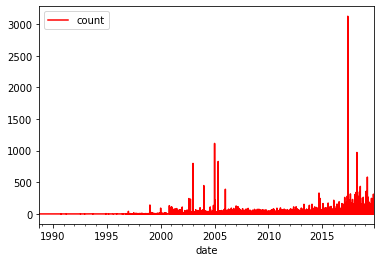

In [24]:
v_d.plot(color="red")

# Correlation Between Release and NVD

We next explore if there is a correlation between vulnerability publish date and spike in frequency

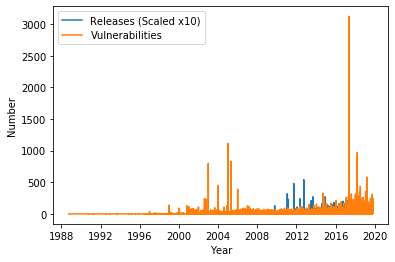

In [25]:
plt.plot(r_d*10, label="Releases (Scaled x10)")
plt.plot(v_d, label="Vulnerabilities")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Number")
plt.show()

#### Exploring basic correlation
Weekly resampling of releases and vulnerabilities

In [26]:
r_w = releases_resample('w')
v_w = vulnerability_resample('w')

Correlation between the sets on daily and weekly basis is calculated

In [27]:
print( r_d['count'].corr(v_d['count']) )
print( r_w['count'].corr(v_w['count']) )

0.13784265436333917
0.2925604121743066


There could potentially be a relationship between vulnerability release and rise in release frequency. Weekly is likely higher as patches are not releases the same day, generally.

These functions are used in the next part of the analysis. They get ranges of dates and calculate the number of releases.

# PROJECT REVIEW #2

In [28]:
def get_delta_date(date, days):
    return (pd.to_datetime(date) + pd.Timedelta(days=days))
    # return np.datetime64((pd.to_datetime(date) + pd.Timedelta(days=days)), 'D')

def get_range(rel_df, start_date, end_date):
    return rel_df[rel_df.date > start_date][rel_df.date < end_date]
   
def get_count(rel_df):
    return rel_df['count'].sum()

def get_range_count(rel_df, start_date, end_date):
    return get_count( get_range(rel_df, start_date, end_date) )

def get_period(rel_df, date, days):
    start_date = get_delta_date(date, -days)
    end_date = get_delta_date(date, days)
    return get_range(rel_df, start_date, end_date)

def get_period_count(rel_df, date, days):
    return get_count(get_priod(rel_df, date, days))
    
def get_period_avg(rel_df, date, days):
    return get_count( get_period(rel_df, date, days) ) / (2*days)

def get_prev_avg(rel_df, date, days):
    return get_count( get_range(rel_df, get_delta_date(date, -days), date ) ) / days

def get_next_avg(rel_df, date, days):
    return get_count( get_range(rel_df, date, get_delta_date(date, days) ) ) / days
def get_next_count(rel_df, date, days):
    return get_count( get_range(rel_df, date, get_delta_date(date, days) ) )

def get_delta_avg(rel_df, date, days):
    return get_next_avg(rel_df, date, days) - get_prev_avg(rel_df, date, days)

# Distribution Modeling

# Hypothesis Testing

### H0: The weeks immediately following a week with a higher number of severe vulnreabilities have the same frequency in releases.

### H: The Weeks immediately following a week with a higher number of severe vulnerabilities have an increased frequency in releases.|

## January 1st, 2016 to January 1st, 2018  is analyzed for consistency
Since the number of releases is not consistent with time, as GitHub is continually growing in popularity, we will select a segment of time with consitent number of releases.
This is around the year 2017.

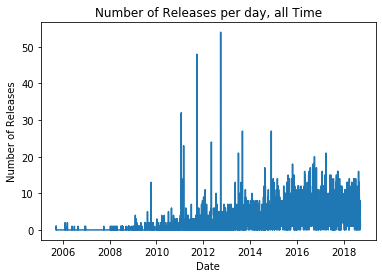

In [29]:
r_d = releases_resample('d').reset_index()
plt.plot(r_d['date'], r_d['count'], color="C0")
plt.title('Number of Releases per day, all Time')
plt.xlabel('Date')
plt.ylabel('Number of Releases')
plt.show()

In [30]:
date = '2017-01-01'
period = 365

In [31]:
# Get the releases from 2016 and 2018
releases_2017 = get_period(releases_resample('d').reset_index(), date, days=period)

Number of releases per week per week.

In [32]:
rel17_w = releases_2017.set_index('date').resample('w').sum().reset_index()

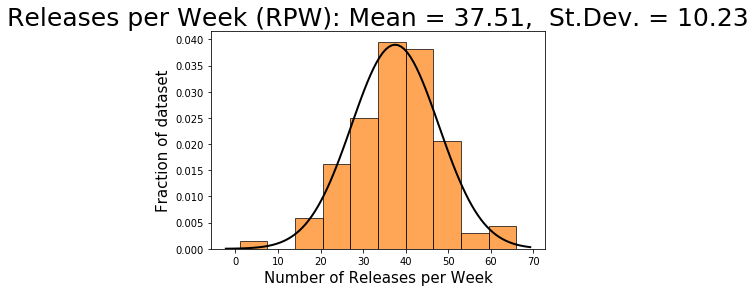

In [33]:
plt.hist(rel17_w['count'].values, bins=10, density=True, linestyle='solid', color = "C1",alpha=0.7, ec="black")
xlim = plt.xlim()
x = np.linspace(xlim[0], xlim[1], 100)

mu,std = norm.fit(rel17_w['count'])
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title('Releases per Week (RPW): Mean = %.2f,  St.Dev. = %.2f' % (mu, std), fontsize=25)
plt.xlabel('Number of Releases per Week', fontsize=15)
plt.ylabel('Fraction of dataset', fontsize=15)

plt.show()

# Basic Statistics of Releases.csv

## The mean number of releases per week (from 2016 to 2018) is

In [34]:
release_mean = rel17_w['count'].mean()
release_mean

37.51428571428571

## The median number of releases per week (from 2016 to 2018) is

In [35]:
release_med = rel17_w['count'].median()
release_med

37.0

### The difference in the mean and median is small, not many outliers.

In [36]:
print(release_mean-release_med)

0.5142857142857125


## The variance in the number of releases per week (from 2016 to 2018) is

In [37]:
release_var = rel17_w['count'].var()
release_var

105.71373626373627

### The variance is very high, meaning the data is not centered around a single mean well.

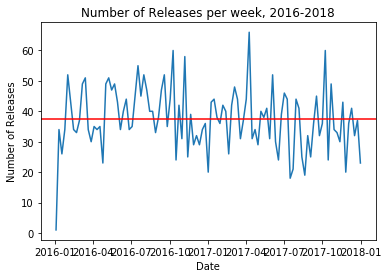

In [38]:
plt.plot(rel17_w['date'], rel17_w['count'], color="C0")
r17_mean = rel17_w['count'].mean()
plt.axhline(r17_mean,  color='r')

plt.title('Number of Releases per week, 2016-2018')
plt.xlabel('Date')
plt.ylabel('Number of Releases')
plt.show()

As I am only exploring number of vulnerabilities per week, I will contain myself to only **severe** vulnerabilities, score 9.0 and up.

In [39]:
# Get the severe (9.0 and up) vulnerabilities from 2016 and 2018
severe_17 = get_period(nvd_clean[ nvd_clean.score >= 9.0], date, days=period)

# Resample publishes per week
sev17_w = severe_17.set_index('date').resample('w').count().reset_index()

# Publishes per Week vs. Releases per Week

Merge the num_vulnerabilities per week with the num_releases per week.

In [40]:
weekly = pd.merge(sev17_w, rel17_w, on='date')

Here we find the weeks with the most published vulnerabilities.

For each of these weeks (most and least vulnerabilities) the number of releases within that same week and the next week are found.

In [41]:
week_most_vuln = weekly.sort_values('score', ascending=False)[0:30]
week_least_vuln = weekly.sort_values('score', ascending=True)[0:30]

num_days_after = 7

most_next = week_most_vuln['date'].apply(lambda x: get_next_count(releases_2017, x, days=num_days_after))
least_next = week_least_vuln['date'].apply(lambda x: get_next_count(releases_2017, x, days=num_days_after))

## Histogram of number of releases per week, the week following the most and least vulnerable weeks.
Histogram of the number of releases between the "most vulnerable" and "least vulnerable" weeks are found.

In [42]:
# most = week_most_vuln['count'].values
# least = week_least_vuln['count'].values
most = most_next
least = least_next
num_bins=9

mu_most,std_most = norm.fit(most)
mu_least,std_least = norm.fit(least)

xlim = [0,70]
x = np.linspace(xlim[0], xlim[1], 100)

p_most = norm.pdf(x, mu_most, std_most)
p_least = norm.pdf(x, mu_least, std_least)

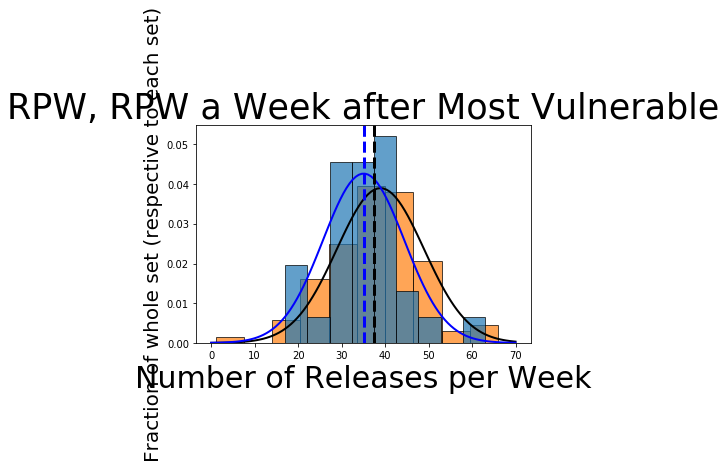

In [43]:
plt.hist(rel17_w['count'].values, bins=10, density=True, linestyle='solid', color = "C1",alpha=0.7, ec="black")
plt.plot(x, p, 'k', linewidth=2)
plt.hist(most, bins=num_bins, density=True, linestyle='solid', color = "C0",alpha=0.7, ec="black")
plt.plot(x, p_most, 'b', linewidth=2)

plt.title('RPW, RPW a Week after Most Vulnerable', fontsize=35)
plt.xlabel('Number of Releases per Week', fontsize=30)
plt.ylabel('Fraction of whole set (respective to each set)', fontsize=20)
plt.axvline(release_mean, color='k', linestyle='--', linewidth=3)
plt.axvline(mu_most, color='b', linestyle='--', linewidth=3)

plt.show()

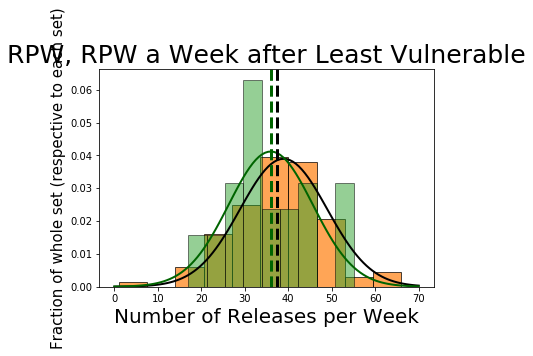

In [44]:
plt.hist(rel17_w['count'].values, bins=10, density=True, linestyle='solid', color = "C1",alpha=0.7, ec="black")
plt.plot(x, p, 'k', linewidth=2)
plt.hist(least, bins=num_bins, density=True, linestyle='solid', color = "C2",alpha=0.5, ec="black")
plt.plot(x, p_least, 'darkgreen', linewidth=2)
plt.axvline(release_mean, color='k', linestyle='--', linewidth=3)
plt.axvline(mu_least, color='darkgreen', linestyle='--', linewidth=3)

plt.title('RPW, RPW a Week after Least Vulnerable', fontsize=25)
plt.xlabel('Number of Releases per Week', fontsize=20)
plt.ylabel('Fraction of whole set (respective to each set)', fontsize=15)

plt.show()

### Two Sample T Test for each High/Low vulnerability

In [45]:
print( stats.ttest_1samp(most, release_mean) )
print( stats.ttest_1samp(least, release_mean) )

print(stats.ttest_ind(most,rel17_w['count']))
print(stats.ttest_ind(least,rel17_w['count']))

stats.ttest_ind(most,least)


Ttest_1sampResult(statistic=-1.4093944903403324, pvalue=0.16935260158105428)
Ttest_1sampResult(statistic=-0.8609855143659614, pvalue=0.39630901317799017)
Ttest_indResult(statistic=-1.168422344959369, pvalue=0.24472655169104)
Ttest_indResult(statistic=-0.7337650176971666, pvalue=0.46438347869725716)


Ttest_indResult(statistic=-0.3600883083446264, pvalue=0.7200890618447146)

## Correlation between Vulnerabilities and Releases

In [46]:
print(sev17_w['score'].corr(most))
print(sev17_w['score'].corr(least))
sev17_w['score'].corr(rel17_w['count'])

0.0246690219115258
-0.023069823190092004


-0.005057449544229407

# Exploration

## Distribution of severity (NVD Score) of all vulnerabilities.

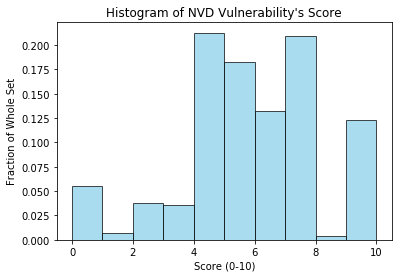

In [47]:
plt.hist(nvd_clean['score'].values, bins=10, density=True,linestyle='solid', color = "skyblue",alpha=0.7, ec="black")

plt.xlabel('Score (0-10)')
plt.ylabel('Fraction of Whole Set')
plt.title('Histogram of NVD Vulnerability\'s Score')
plt.show()

## Bar Graph of num_vulnerabilities per week with num_releases per week

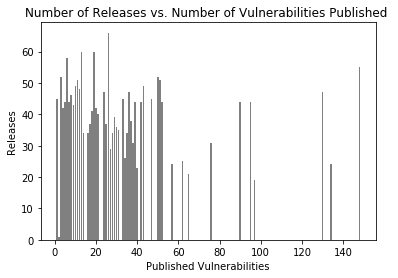

In [48]:
plt.bar(weekly['score'], weekly['count'], color='gray')
plt.title('Number of Releases vs. Number of Vulnerabilities Published ')
plt.xlabel('Published Vulnerabilities')
plt.ylabel('Releases')
plt.show()